# Step 2 - Blackbox Evaluator

This notebook evaluates a Blackbox network so we can use its output to train a descriminator

## Imports

In [1]:
import tensorflow as tf
tf.keras.backend.clear_session()  # For easy reset of notebook state.
from tensorflow import keras  # Import the tf version of keras.
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import keras.backend as K
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm
import pickle

import os.path
import shutil
import math
import random

In [3]:
# Setting seeds for reproducibility 
np.random.seed(0)
tf.set_random_seed(0)

# Enlargen plots
plt.rcParams['figure.figsize'] = [10, 5]

## Parameters

In [4]:
# model params
num_classes = 10
max_epochs = 25
save_every = 1

# client params
clients_per_class = 100                         # number of clients per label. Each client only has access to one label
                                                # - each unique class is divided into X number of subsets
    
minibatch_size = None                           # number of samples to operate on at one time
                                                # - can vary to optimize computing requirements
                                                # - if None, will evaluate the client's whole batch regardless of its size
    
batches_per_train_step = 20                     # after averaging the gradients from X clients, we will apply them to the model

shuffle_clients = True

# dataset params
separated_folder = "./separated_dataset"
os.makedirs(separated_folder, exist_ok=True)
separated_train_path = os.path.join(separated_folder, "train_separated.pkl")
separated_test_path = os.path.join(separated_folder, "test_separated.pkl")

# input image dimensions
img_rows, img_cols = 28, 28
target_rows, target_cols = 28, 28    # governed by the chosen model

## Load Data

In [5]:
# The data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

if target_rows != img_rows or target_cols != img_cols:
    # resize x_train
    x_train_resized = []
    for x_ in x_train:
        # scale image to be the same WxH as we need:
        x_ = cv2.resize(x_, dsize=(target_rows, target_cols), interpolation=cv2.INTER_CUBIC)
        x_train_resized.append(x_)
    x_train = np.asarray(x_train_resized)

    # resize x_test
    x_test_resized = []
    for x_ in x_test:
        # scale image to be the same WxH as we need:
        x_ = cv2.resize(x_, dsize=(target_rows, target_cols), interpolation=cv2.INTER_CUBIC)
        x_test_resized.append(x_)
    x_test = np.asarray(x_test_resized)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
# summary of data shapes:
print('X:', x_train.shape, x_test.shape)
print('y:', y_train.shape, y_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

X: (60000, 28, 28, 1) (10000, 28, 28, 1)
y: (60000, 10) (10000, 10)
60000 train samples
10000 test samples


#### Separate the data by class

In [7]:
# Separating the data by class
if os.path.isfile(separated_train_path):
    with open(separated_train_path, 'rb') as f:
        x_train_dict, y_train_dict = pickle.load(f)
        print('loaded training seperation')
else:
    x_train_dict = {}
    y_train_dict = {}
    for target_label in tqdm_notebook(range(10)):
        x_train_dict[target_label] = []
        y_train_dict[target_label] = []
        for i, label in enumerate(y_train):
            if list(label).index(1) == target_label:
                x_train_dict[target_label].append(x_train[i])
                y_train_dict[target_label].append(y_train[i])
    
    with open(separated_train_path, 'wb') as f:
        pickle.dump([x_train_dict, y_train_dict], f)
        print('saved training seperation')

if os.path.isfile(separated_test_path):
    with open(separated_test_path, 'rb') as f:
        x_test_dict, y_test_dict = pickle.load(f)
        print('loaded testing seperation')
else:
    x_test_dict = {}
    y_test_dict = {}
    for target_label in tqdm_notebook(range(10)):
        x_test_dict[target_label] = []
        y_test_dict[target_label] = []
        for i, label in enumerate(y_test):
            if list(label).index(1) == target_label:
                x_test_dict[target_label].append(x_test[i])
                y_test_dict[target_label].append(y_test[i])

    with open(separated_test_path, 'wb') as f:
        pickle.dump([x_test_dict, y_test_dict], f)
        print('saved testing seperation')
    
# convert dicts to lists
x_train_seperated = [np.array(x_train_dict[i]) for i in range(10)]
y_train_seperated = [np.array(y_train_dict[i]) for i in range(10)]

x_test_seperated = [np.array(x_test_dict[i]) for i in range(10)]
y_test_seperated = [np.array(y_test_dict[i]) for i in range(10)]

loaded training seperation
loaded testing seperation


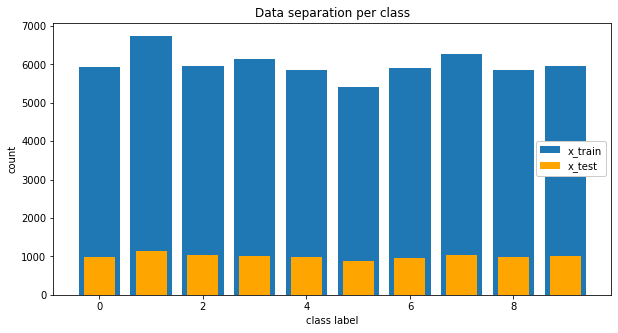

In [8]:
# summary of data shapes:
plt.figure()
plt.title('Data separation per class')
plt.bar(x_train_dict.keys(), [len(v) for v in x_train_dict.values()], color='tab:blue')
plt.bar(x_test_dict.keys(), [len(v) for v in x_test_dict.values()], color='orange', width=0.6)
plt.legend(['x_train', 'x_test'], loc='center right', framealpha=1.0)
plt.xlabel('class label')
plt.ylabel('count')
plt.show()

#### Separate the data into batches for clients to use

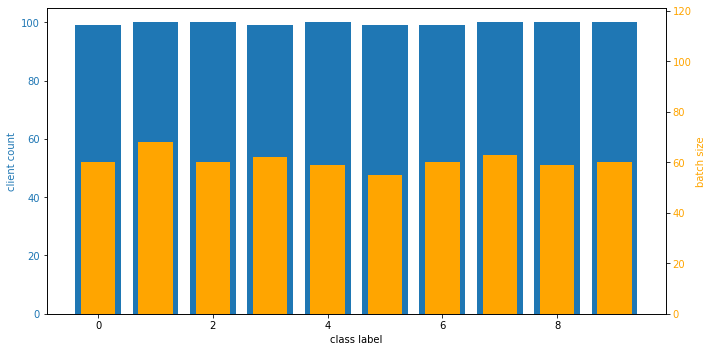

Clients per class:  99.6 ~= 100
Total number of clients: 996
Average batch size: 60.6


In [9]:
# Separate the data into a long list of batches, each batch representing a client training with that batch of images.
# After each batch, a new client will have the opportunity to train their batch of images.
# Batches are shuffled to simulate many clients training the model at once.

client_counts = {}
batch_sizes = {}
x_batches = []
y_batches = []

def ceil(a,b):
    return -(-a//b)

for class_idx in range(len(x_train_seperated)):
    # Get batches from class data:
    n_samples_per_class = len(x_train_seperated[class_idx])
    samples_per_client = n_samples_per_class / clients_per_class
    better_batch_size = int(math.ceil(samples_per_client))

    count = 0
    for i in range(ceil(n_samples_per_class, better_batch_size)):
        x_batches.append((class_idx, x_train_seperated[class_idx][i * better_batch_size: (i+1) * better_batch_size]))
        y_batches.append((class_idx, y_train_seperated[class_idx][i * better_batch_size: (i+1) * better_batch_size]))
        count += 1
    client_counts[class_idx] = count
    batch_sizes[class_idx] = better_batch_size
        
# double check that the clients_per_class is upheld per class
# (blue bars should be uniform, orange should change according to class):
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('class label')
ax1.set_ylabel('client count', color=color)
plt.bar(client_counts.keys(), [v for v in client_counts.values()], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'orange'
ax2.set_ylabel('batch size', color=color)  # we already handled the x-label with ax1
plt.bar(batch_sizes.keys(), [v for v in batch_sizes.values()], color=color, width=0.6)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, np.mean([v for v in batch_sizes.values()])*2)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

print('Clients per class:  {} ~= {}'.format(np.mean([v for v in client_counts.values()]), clients_per_class))
print('Total number of clients: {}'.format(np.sum([v for v in client_counts.values()])))
print('Average batch size: {}'.format(np.mean([v for v in batch_sizes.values()])))

## Build Model

In [10]:
def create_model(input_layer, depth=1, filters=4, dense_breadth=128, training=True):
    assert depth >= 1
    assert filters >= 1
    assert dense_breadth >= num_classes
    
    h = Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape)(input_layer)
    for i in range(depth-1):
        h = Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same')(h)
    h = MaxPooling2D(pool_size=(2, 2))(h)
    h = Dropout(0.25)(h, training=training)
    h = Flatten()(h)
    h = Dense(dense_breadth, activation='relu')(h)
    h = Dropout(0.5)(h, training=training)
    output_layer = Dense(num_classes, activation='softmax')(h)
    
    return output_layer

In [11]:
input_shape = (target_rows, target_cols, 1)

## Graph Creation

In [12]:
class BlackBoxModel:
    
    def __init__(self, input_shape, depth, filters, dense, training=True):
        self.input_shape = input_shape
        self.training = training
        self.depth = depth
        self.filters = filters
        self.dense = dense
        
        self.accumulate_ops = None
        self.train_step = None
        self.zero_ops = None
        
        self.create_graph()
        self.create_optimizer()
        self.split_learning_ops()
        
    def create_graph(self):
        # add place for input and pred label
        self.x = keras.Input(shape=self.input_shape)
        self.y_pred = create_model(self.x, self.depth, self.filters, self.dense, training=self.training)

        # add place for truth label
        self.y_true = keras.Input(shape=(num_classes, ))
        
    def create_optimizer(self):
        # define loss function in terms of y_pred and y_true
        self.loss = keras.losses.categorical_crossentropy(self.y_true, self.y_pred)

        # Setup metrics to look at during training:
        _, self.acc_op = tf.metrics.accuracy(labels=tf.argmax(self.y_true, 1),
                                             predictions=tf.argmax(self.y_pred,1))

        ## Optimizer definition - nothing different from any classical example
        self.optimizer = tf.train.AdamOptimizer()

        # Add ops to save and restore all the variables.
        self.saver = tf.train.Saver(max_to_keep=max_epochs)
        
    def split_learning_ops(self):
        # INSPIRED by https://stackoverflow.com/questions/42156957/how-to-update-model-parameters-with-accumulated-gradients

        # Fetch a list of our network's trainable parameters.
        self.trainable_vars = tf.trainable_variables()

        # Create variables to store accumulated gradients
        self.accumulators = [
            tf.Variable(
                tf.zeros_like(tv.initialized_value()),
                trainable=False
            ) for tv in self.trainable_vars
        ]

        # Create a variable for counting the number of accumulations
        self.accumulation_counter = tf.Variable(0.0, trainable=False)

        # Compute gradients; grad_pairs contains (gradient, variable) pairs
        self.grad_pairs = self.optimizer.compute_gradients(self.loss, self.trainable_vars)

        # Create operations which add a variable's gradient to its accumulator.
        self.accumulate_ops = [
            accumulator.assign_add(
                grad
            ) for (accumulator, (grad, var)) in zip(self.accumulators, self.grad_pairs)
        ]

        # The final accumulation operation is to increment the counter
        self.accumulate_ops.append(self.accumulation_counter.assign_add(1.0))

        # Update trainable variables by applying the accumulated gradients
        # divided by the counter. Note: apply_gradients takes in a list of 
        # (grad, var) pairs
        self.train_step = self.optimizer.apply_gradients(
            [(accumulator / self.accumulation_counter, var) \
                for (accumulator, (grad, var)) in zip(self.accumulators, self.grad_pairs)]
        )

        # Accumulators must be zeroed once the accumulated gradient is applied.
        self.zero_ops = [
            accumulator.assign(
                tf.zeros_like(tv)
            ) for (accumulator, tv) in zip(self.accumulators, self.trainable_vars)
        ]

        # Add one last op for zeroing the counter
        self.zero_ops.append(self.accumulation_counter.assign(0.0))
        
    def count_params(self):
        # create a model representation
        model_ = keras.Model(inputs=self.x, outputs=self.y_pred)
        
        # return the number of parameters
        return model_.count_params()

## Save evaluations

In [13]:
# List of the different configurations we will step through

configs_depth = list(range(1, 11, 4))
configs_filters = list(range(1, 81, 32))
configs_dense = list(range(10, 200, 100))
total_combinations = len(configs_depth) * len(configs_filters) * len(configs_dense)

print('{} total combinations of networks'.format(total_combinations))
print('depths:', configs_depth)
print('filters:', configs_filters)
print('denses:', configs_dense)

100 total combinations of networks
depths: [1, 3, 5, 7, 9]
filters: [1, 17, 33, 49, 65]
denses: [10, 60, 110, 160]


In [14]:
print('Evaluating the model...\n')

inc = 0
for depth in configs_depth:
    for filters in configs_filters:
        for dense in configs_dense:
            
            print('{}/{}'.format(inc+1, total_combinations)+'='*40)
            print('Evaluating blackbox_e{}_d{}_f{}_d{}'.format(max_epochs, depth, filters, dense))
            filename = "blackbox_e{}_d{}_f{}_d{}".format(max_epochs, depth, filters, dense)
            
            # train a new model each time:
            model_obj = BlackBoxModel(input_shape, depth, filters, dense, training=True)
            
            param_count = model_obj.count_params()
            
            with tf.Session() as sess:
                # init the session:
                sess.run(tf.local_variables_initializer())
                sess.run(tf.global_variables_initializer())
                
                # load the weights for the blackbox:
                checkpoint_folder = "./blackbox_checkpoints/{}".format(filename)
                blackbox_weights_path = os.path.join(checkpoint_folder, 'blackbox_checkpoint')
                # model.load_weights(blackbox_weights_path)
                model_obj.saver.restore(sess, blackbox_weights_path)

                # Calculate test acc and loss - to double check loader is working
                acc_test, loss_test = sess.run([model_obj.acc_op, model_obj.loss], 
                                               feed_dict={model_obj.x: x_test, model_obj.y_true: y_test})
                print('Test Accuracy: {:.3f} | Loss: {:.3f}'.format(acc_test, np.mean(loss_test)))
                print()
                
                # evaluate the model for all training data:
                eval_folder = "./blackbox_evals/{}".format(filename)
                if os.path.exists(eval_folder):
                    shutil.rmtree(eval_folder)
                os.makedirs(eval_folder, exist_ok=True)

                batch_idxs = list(range(len(x_batches)))
                for batch_idx in tqdm_notebook(batch_idxs):
                    class_idx, x_batch = x_batches[batch_idx]
                    _, y_batch = y_batches[batch_idx]

                    # save output of every batch to a pickle file:
                    y_eval = sess.run(model_obj.y_pred, feed_dict={model_obj.x: x_batch})

                    eval_file = os.path.join(eval_folder, 'train_{}.pkl'.format(batch_idx))
                    with open(eval_file, 'wb') as f:
                        pickle.dump(y_eval, f)

                # evaluate and save the model for all testing data:
                y_eval = sess.run(model_obj.y_pred, feed_dict={model_obj.x: x_test})

                eval_file = os.path.join(eval_folder, 'test_all.pkl')
                with open(eval_file, 'wb') as f:
                    pickle.dump(y_eval, f)
                    
                # dump param number to file:
                param_file = os.path.join(eval_folder, 'param_count.pkl')
                with open(param_file, 'wb') as f:
                    pickle.dump(param_count, f)
                
            # Flush out the session
            keras.backend.clear_session()

Evaluating the model...

Evaluating blackbox_e25_d1_f1_d10
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d1_f1_d10\blackbox_checkpoint
Test Accuracy: 0.940 | Loss: 0.197




Evaluating blackbox_e25_d1_f1_d60
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d1_f1_d60\blackbox_checkpoint
Test Accuracy: 0.951 | Loss: 0.158




Evaluating blackbox_e25_d1_f1_d110
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d1_f1_d110\blackbox_checkpoint
Test Accuracy: 0.938 | Loss: 0.203




Evaluating blackbox_e25_d1_f1_d160
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d1_f1_d160\blackbox_checkpoint
Test Accuracy: 0.953 | Loss: 0.151




Evaluating blackbox_e25_d1_f17_d10
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d1_f17_d10\blackbox_checkpoint
Test Accuracy: 0.942 | Loss: 0.196




Evaluating blackbox_e25_d1_f17_d60
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d1_f17_d60\blackbox_checkpoint
Test Accuracy: 0.947 | Loss: 0.170




Evaluating blackbox_e25_d1_f17_d110
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d1_f17_d110\blackbox_checkpoint
Test Accuracy: 0.953 | Loss: 0.156




Evaluating blackbox_e25_d1_f17_d160
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d1_f17_d160\blackbox_checkpoint
Test Accuracy: 0.951 | Loss: 0.154




Evaluating blackbox_e25_d1_f33_d10
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d1_f33_d10\blackbox_checkpoint
Test Accuracy: 0.941 | Loss: 0.196




Evaluating blackbox_e25_d1_f33_d60
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d1_f33_d60\blackbox_checkpoint
Test Accuracy: 0.946 | Loss: 0.183




Evaluating blackbox_e25_d1_f33_d110
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d1_f33_d110\blackbox_checkpoint
Test Accuracy: 0.941 | Loss: 0.191




Evaluating blackbox_e25_d1_f33_d160
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d1_f33_d160\blackbox_checkpoint
Test Accuracy: 0.947 | Loss: 0.177




Evaluating blackbox_e25_d1_f49_d10
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d1_f49_d10\blackbox_checkpoint
Test Accuracy: 0.942 | Loss: 0.181




Evaluating blackbox_e25_d1_f49_d60
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d1_f49_d60\blackbox_checkpoint
Test Accuracy: 0.948 | Loss: 0.168




Evaluating blackbox_e25_d1_f49_d110
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d1_f49_d110\blackbox_checkpoint
Test Accuracy: 0.946 | Loss: 0.179




Evaluating blackbox_e25_d1_f49_d160
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d1_f49_d160\blackbox_checkpoint
Test Accuracy: 0.951 | Loss: 0.172




Evaluating blackbox_e25_d1_f65_d10
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d1_f65_d10\blackbox_checkpoint
Test Accuracy: 0.939 | Loss: 0.200




Evaluating blackbox_e25_d1_f65_d60
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d1_f65_d60\blackbox_checkpoint
Test Accuracy: 0.946 | Loss: 0.180




Evaluating blackbox_e25_d1_f65_d110
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d1_f65_d110\blackbox_checkpoint
Test Accuracy: 0.934 | Loss: 0.217




Evaluating blackbox_e25_d1_f65_d160
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d1_f65_d160\blackbox_checkpoint
Test Accuracy: 0.945 | Loss: 0.173




Evaluating blackbox_e25_d3_f1_d10
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d3_f1_d10\blackbox_checkpoint
Test Accuracy: 0.947 | Loss: 0.175




Evaluating blackbox_e25_d3_f1_d60
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d3_f1_d60\blackbox_checkpoint
Test Accuracy: 0.949 | Loss: 0.173




Evaluating blackbox_e25_d3_f1_d110
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d3_f1_d110\blackbox_checkpoint
Test Accuracy: 0.939 | Loss: 0.197




Evaluating blackbox_e25_d3_f1_d160
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d3_f1_d160\blackbox_checkpoint
Test Accuracy: 0.941 | Loss: 0.198




Evaluating blackbox_e25_d3_f17_d10
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d3_f17_d10\blackbox_checkpoint
Test Accuracy: 0.938 | Loss: 0.203




Evaluating blackbox_e25_d3_f17_d60
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d3_f17_d60\blackbox_checkpoint
Test Accuracy: 0.947 | Loss: 0.160




Evaluating blackbox_e25_d3_f17_d110
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d3_f17_d110\blackbox_checkpoint
Test Accuracy: 0.940 | Loss: 0.192




Evaluating blackbox_e25_d3_f17_d160
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d3_f17_d160\blackbox_checkpoint
Test Accuracy: 0.950 | Loss: 0.161




Evaluating blackbox_e25_d3_f33_d10
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d3_f33_d10\blackbox_checkpoint
Test Accuracy: 0.945 | Loss: 0.184




Evaluating blackbox_e25_d3_f33_d60
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d3_f33_d60\blackbox_checkpoint
Test Accuracy: 0.954 | Loss: 0.156




Evaluating blackbox_e25_d3_f33_d110
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d3_f33_d110\blackbox_checkpoint
Test Accuracy: 0.954 | Loss: 0.147




Evaluating blackbox_e25_d3_f33_d160
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d3_f33_d160\blackbox_checkpoint
Test Accuracy: 0.939 | Loss: 0.193




Evaluating blackbox_e25_d3_f49_d10
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d3_f49_d10\blackbox_checkpoint
Test Accuracy: 0.947 | Loss: 0.173




Evaluating blackbox_e25_d3_f49_d60
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d3_f49_d60\blackbox_checkpoint
Test Accuracy: 0.933 | Loss: 0.216




Evaluating blackbox_e25_d3_f49_d110
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d3_f49_d110\blackbox_checkpoint
Test Accuracy: 0.940 | Loss: 0.191




Evaluating blackbox_e25_d3_f49_d160
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d3_f49_d160\blackbox_checkpoint
Test Accuracy: 0.938 | Loss: 0.200




Evaluating blackbox_e25_d3_f65_d10
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d3_f65_d10\blackbox_checkpoint
Test Accuracy: 0.938 | Loss: 0.196




Evaluating blackbox_e25_d3_f65_d60
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d3_f65_d60\blackbox_checkpoint
Test Accuracy: 0.951 | Loss: 0.156




Evaluating blackbox_e25_d3_f65_d110
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d3_f65_d110\blackbox_checkpoint
Test Accuracy: 0.940 | Loss: 0.191




Evaluating blackbox_e25_d3_f65_d160
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d3_f65_d160\blackbox_checkpoint
Test Accuracy: 0.949 | Loss: 0.177




Evaluating blackbox_e25_d5_f1_d10
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d5_f1_d10\blackbox_checkpoint
Test Accuracy: 0.949 | Loss: 0.168




Evaluating blackbox_e25_d5_f1_d60
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d5_f1_d60\blackbox_checkpoint
Test Accuracy: 0.938 | Loss: 0.199




Evaluating blackbox_e25_d5_f1_d110
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d5_f1_d110\blackbox_checkpoint
Test Accuracy: 0.941 | Loss: 0.194




Evaluating blackbox_e25_d5_f1_d160
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d5_f1_d160\blackbox_checkpoint
Test Accuracy: 0.940 | Loss: 0.194




Evaluating blackbox_e25_d5_f17_d10
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d5_f17_d10\blackbox_checkpoint
Test Accuracy: 0.954 | Loss: 0.151




Evaluating blackbox_e25_d5_f17_d60
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d5_f17_d60\blackbox_checkpoint
Test Accuracy: 0.948 | Loss: 0.171




Evaluating blackbox_e25_d5_f17_d110
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d5_f17_d110\blackbox_checkpoint
Test Accuracy: 0.949 | Loss: 0.160




Evaluating blackbox_e25_d5_f17_d160
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d5_f17_d160\blackbox_checkpoint
Test Accuracy: 0.945 | Loss: 0.181




Evaluating blackbox_e25_d5_f33_d10
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d5_f33_d10\blackbox_checkpoint
Test Accuracy: 0.948 | Loss: 0.174




Evaluating blackbox_e25_d5_f33_d60
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d5_f33_d60\blackbox_checkpoint
Test Accuracy: 0.940 | Loss: 0.199




Evaluating blackbox_e25_d5_f33_d110
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d5_f33_d110\blackbox_checkpoint
Test Accuracy: 0.947 | Loss: 0.174




Evaluating blackbox_e25_d5_f33_d160
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d5_f33_d160\blackbox_checkpoint
Test Accuracy: 0.949 | Loss: 0.171




Evaluating blackbox_e25_d5_f49_d10
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d5_f49_d10\blackbox_checkpoint
Test Accuracy: 0.946 | Loss: 0.188




Evaluating blackbox_e25_d5_f49_d60
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d5_f49_d60\blackbox_checkpoint
Test Accuracy: 0.954 | Loss: 0.156




Evaluating blackbox_e25_d5_f49_d110
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d5_f49_d110\blackbox_checkpoint
Test Accuracy: 0.931 | Loss: 0.227




Evaluating blackbox_e25_d5_f49_d160
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d5_f49_d160\blackbox_checkpoint
Test Accuracy: 0.941 | Loss: 0.197




Evaluating blackbox_e25_d5_f65_d10
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d5_f65_d10\blackbox_checkpoint
Test Accuracy: 0.951 | Loss: 0.160




Evaluating blackbox_e25_d5_f65_d60
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d5_f65_d60\blackbox_checkpoint
Test Accuracy: 0.953 | Loss: 0.155




Evaluating blackbox_e25_d5_f65_d110
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d5_f65_d110\blackbox_checkpoint
Test Accuracy: 0.945 | Loss: 0.182




Evaluating blackbox_e25_d5_f65_d160
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d5_f65_d160\blackbox_checkpoint
Test Accuracy: 0.948 | Loss: 0.164




Evaluating blackbox_e25_d7_f1_d10
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d7_f1_d10\blackbox_checkpoint
Test Accuracy: 0.950 | Loss: 0.166




Evaluating blackbox_e25_d7_f1_d60
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d7_f1_d60\blackbox_checkpoint
Test Accuracy: 0.945 | Loss: 0.177




Evaluating blackbox_e25_d7_f1_d110
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d7_f1_d110\blackbox_checkpoint
Test Accuracy: 0.951 | Loss: 0.156




Evaluating blackbox_e25_d7_f1_d160
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d7_f1_d160\blackbox_checkpoint
Test Accuracy: 0.946 | Loss: 0.172




Evaluating blackbox_e25_d7_f17_d10
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d7_f17_d10\blackbox_checkpoint
Test Accuracy: 0.941 | Loss: 0.182




Evaluating blackbox_e25_d7_f17_d60
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d7_f17_d60\blackbox_checkpoint
Test Accuracy: 0.941 | Loss: 0.199




Evaluating blackbox_e25_d7_f17_d110
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d7_f17_d110\blackbox_checkpoint
Test Accuracy: 0.947 | Loss: 0.173




Evaluating blackbox_e25_d7_f17_d160
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d7_f17_d160\blackbox_checkpoint
Test Accuracy: 0.932 | Loss: 0.223




Evaluating blackbox_e25_d7_f33_d10
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d7_f33_d10\blackbox_checkpoint
Test Accuracy: 0.937 | Loss: 0.204




Evaluating blackbox_e25_d7_f33_d60
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d7_f33_d60\blackbox_checkpoint
Test Accuracy: 0.953 | Loss: 0.156




Evaluating blackbox_e25_d7_f33_d110
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d7_f33_d110\blackbox_checkpoint
Test Accuracy: 0.939 | Loss: 0.203




Evaluating blackbox_e25_d7_f33_d160
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d7_f33_d160\blackbox_checkpoint
Test Accuracy: 0.950 | Loss: 0.168




Evaluating blackbox_e25_d7_f49_d10
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d7_f49_d10\blackbox_checkpoint
Test Accuracy: 0.936 | Loss: 0.212




Evaluating blackbox_e25_d7_f49_d60
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d7_f49_d60\blackbox_checkpoint
Test Accuracy: 0.951 | Loss: 0.157




Evaluating blackbox_e25_d7_f49_d110
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d7_f49_d110\blackbox_checkpoint
Test Accuracy: 0.954 | Loss: 0.151




Evaluating blackbox_e25_d7_f49_d160
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d7_f49_d160\blackbox_checkpoint
Test Accuracy: 0.953 | Loss: 0.152




Evaluating blackbox_e25_d7_f65_d10
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d7_f65_d10\blackbox_checkpoint
Test Accuracy: 0.955 | Loss: 0.150




Evaluating blackbox_e25_d7_f65_d60
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d7_f65_d60\blackbox_checkpoint
Test Accuracy: 0.945 | Loss: 0.169




Evaluating blackbox_e25_d7_f65_d110
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d7_f65_d110\blackbox_checkpoint
Test Accuracy: 0.948 | Loss: 0.169




Evaluating blackbox_e25_d7_f65_d160
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d7_f65_d160\blackbox_checkpoint
Test Accuracy: 0.956 | Loss: 0.142




Evaluating blackbox_e25_d9_f1_d10
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d9_f1_d10\blackbox_checkpoint
Test Accuracy: 0.946 | Loss: 0.176




Evaluating blackbox_e25_d9_f1_d60
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d9_f1_d60\blackbox_checkpoint
Test Accuracy: 0.944 | Loss: 0.180




Evaluating blackbox_e25_d9_f1_d110
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d9_f1_d110\blackbox_checkpoint
Test Accuracy: 0.956 | Loss: 0.147




Evaluating blackbox_e25_d9_f1_d160
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d9_f1_d160\blackbox_checkpoint
Test Accuracy: 0.931 | Loss: 0.225




Evaluating blackbox_e25_d9_f17_d10
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d9_f17_d10\blackbox_checkpoint
Test Accuracy: 0.951 | Loss: 0.158




Evaluating blackbox_e25_d9_f17_d60
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d9_f17_d60\blackbox_checkpoint
Test Accuracy: 0.949 | Loss: 0.168




Evaluating blackbox_e25_d9_f17_d110
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d9_f17_d110\blackbox_checkpoint
Test Accuracy: 0.950 | Loss: 0.164




Evaluating blackbox_e25_d9_f17_d160
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d9_f17_d160\blackbox_checkpoint
Test Accuracy: 0.951 | Loss: 0.161




Evaluating blackbox_e25_d9_f33_d10
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d9_f33_d10\blackbox_checkpoint
Test Accuracy: 0.952 | Loss: 0.151




Evaluating blackbox_e25_d9_f33_d60
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d9_f33_d60\blackbox_checkpoint
Test Accuracy: 0.950 | Loss: 0.160




Evaluating blackbox_e25_d9_f33_d110
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d9_f33_d110\blackbox_checkpoint
Test Accuracy: 0.951 | Loss: 0.165




Evaluating blackbox_e25_d9_f33_d160
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d9_f33_d160\blackbox_checkpoint
Test Accuracy: 0.939 | Loss: 0.211




Evaluating blackbox_e25_d9_f49_d10
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d9_f49_d10\blackbox_checkpoint
Test Accuracy: 0.948 | Loss: 0.171




Evaluating blackbox_e25_d9_f49_d60
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d9_f49_d60\blackbox_checkpoint
Test Accuracy: 0.950 | Loss: 0.167




Evaluating blackbox_e25_d9_f49_d110
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d9_f49_d110\blackbox_checkpoint
Test Accuracy: 0.952 | Loss: 0.158




Evaluating blackbox_e25_d9_f49_d160
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d9_f49_d160\blackbox_checkpoint
Test Accuracy: 0.945 | Loss: 0.180




Evaluating blackbox_e25_d9_f65_d10
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d9_f65_d10\blackbox_checkpoint
Test Accuracy: 0.956 | Loss: 0.143




Evaluating blackbox_e25_d9_f65_d60
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d9_f65_d60\blackbox_checkpoint
Test Accuracy: 0.949 | Loss: 0.163




Evaluating blackbox_e25_d9_f65_d110
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d9_f65_d110\blackbox_checkpoint
Test Accuracy: 0.939 | Loss: 0.200




Evaluating blackbox_e25_d9_f65_d160
INFO:tensorflow:Restoring parameters from ./blackbox_checkpoints/blackbox_e25_d9_f65_d160\blackbox_checkpoint
Test Accuracy: 0.944 | Loss: 0.185

